---
title: "Lazy resampling"
# categories: [xarray]
# date: 2025-04-25
---

Example on how to lazily resample a `xarray.Dataset` or `xarray.DataArray` with dask using `odc.geo.xr.xr_reproject`

In [1]:
import sys
import numpy as np
import xarray as xr
from rasterio.enums import Resampling
import odc.geo
from odc.geo.xr import xr_reproject
from odc.geo.geobox import GeoBox, BoundingBox

In [2]:
print(sys.version)
print(xr.__version__)
print(odc.geo.__version__)

3.13.1 | packaged by conda-forge | (main, Dec  5 2024, 21:23:54) [GCC 13.3.0]
2025.3.1
0.4.10


The following function is only to simluate that the crs, while initially present on the opened dataset, can get lost easily along the way in workflows, leading to the reprojection to fail. This is not a shortcoming of xarray or `xr_reproject`, but I want to document it, as this happened to me several times before.

In [3]:
def replace_2_by_0(da: xr.DataArray) -> xr.DataArray:
    """Replace 2s by 0"""
    return da.where(da != 2, 0)

In [4]:
ds_webcam = xr.open_zarr("./data/webcam_snow_cover.zarr")

In [5]:
ds_webcam["nodata"] = np.nan

### Check that important info on crs is present

In [6]:
assert ds_webcam.odc.geobox

In [7]:
assert ds_webcam.odc.crs

### Construct geobox needed for `xr_reproject`

In [8]:
xmin, xmax = 656320.0, 661020.0
ymax, ymin = 5213480.0, 5209240.0

lower_res = 20 # target resolution in meters

epsg_code = 25832

In [9]:
bbox = BoundingBox(left=xmin, top=ymax, bottom=ymin, right=xmax)
geobox = GeoBox.from_bbox(bbox=bbox, crs=epsg_code, resolution=lower_res)

### Perform computation on dataset

I sometimes use `xr.DataArray` objects in computations. It is easy to oversee that the data array (here `ds_webcam.snow_cover`) does not inherit or carry over all the important information (`.odc.crs` and `.odc.geobox`) present on the parent dataset object (`ds_webcam`) when used in computations.

In [10]:
# perform the dummy operation
snow_cover = replace_2_by_0(ds_webcam.snow_cover)

In [ ]:
# geobox is present!
assert snow_cover.odc.geobox

/home/<user>/miniconda3/envs/satpy/lib/python3.13/site-packages/odc/geo/_xr_interop.py:503: UserWarning: grid_mapping=spatial_ref is not pointing to valid coordinate
  warnings.warn(


In [12]:
# but the crs is not (as the above warning indicates)
snow_cover.odc.crs

To me this was initially counter intuitive, as the parent dataset has the complete information:

In [13]:
ds_webcam.odc.crs

CRS('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]')

Let's fix that:

In [14]:
snow_cover = snow_cover.odc.assign_crs("epsg:25832")

### Check source no data value and set correctly

In [15]:
# show that nodata attribute is missing
assert getattr(snow_cover, "nodata", None) is None

In [16]:
# add nodata attribute
snow_cover["nodata"] = np.nan

### Perform lazy resampling

In [17]:
snow_cover_downsampled = xr_reproject(snow_cover, geobox, resampling=Resampling.mode)
snow_cover_downsampled.name = "snow_cover"

Which returns a dask-backed dataarray:

In [18]:
snow_cover_downsampled

<xarray.DataArray 'snow_cover' (time: 1, y: 212, x: 235)> Size: 399kB
dask.array<reproject, shape=(1, 212, 235), dtype=float64, chunksize=(1, 212, 235), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 8B 2021-07-15
    nodata       float64 8B nan
  * y            (y) float64 2kB 5.213e+06 5.213e+06 ... 5.209e+06 5.209e+06
  * x            (x) float64 2kB 6.563e+05 6.564e+05 ... 6.61e+05 6.61e+05
    spatial_ref  int32 4B 25832
Attributes:
    AREA_OR_POINT:  Area

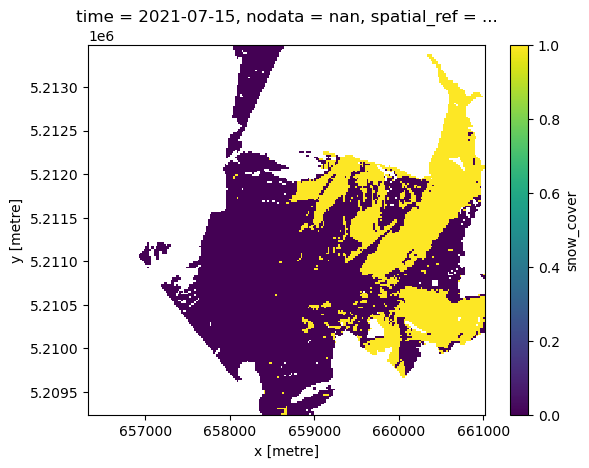

In [19]:
snow_cover_downsampled.plot()